<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Unnormalised-Mixture-of-two-Gaussians" data-toc-modified-id="Unnormalised-Mixture-of-two-Gaussians-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Unnormalised Mixture of two Gaussians</a></span><ul class="toc-item"><li><span><a href="#Applying-variational-EM-type-algorithm-to-the-unnormalised-model" data-toc-modified-id="Applying-variational-EM-type-algorithm-to-the-unnormalised-model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Applying variational EM-type algorithm to the unnormalised model</a></span></li><li><span><a href="#NCE-objective-function" data-toc-modified-id="NCE-objective-function-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>NCE objective function</a></span></li><li><span><a href="#First-lower-bound" data-toc-modified-id="First-lower-bound-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>First lower bound</a></span></li></ul></li></ul></div>

# Unnormalised Mixture of two Gaussians

Previously, in notebooks 1 & 2, we considered the **normalised** mixture of gaussian model family:

$$ \phi(u, z; \theta) = \frac{1}{2}(1-z) \frac{1}{\sqrt{2 \pi} \theta} e^{-\frac{u^2}{2 \theta^2}} + \frac{1}{2}z \frac{1}{\sqrt{2 \pi} \sigma_1} e^{-\frac{u^2}{2 \sigma_1^2}} $$

Below, we consider the **unnormalised** mixture of gaussian model family, with an additional scaling parameter $c$:

\begin{align}
\phi(u, z; \theta, c) & = e^{-c} \left( (1-z) e^{-\frac{u^2}{2 \theta^2}} + z e^{-\frac{u^2}{2 \sigma_1^2}} \right) \\
                   & = e^{-c} \sqrt{2 \pi} \left( (1-z)  \theta \mathcal{N}(u, \theta) + 
                                            z \sigma_1 \mathcal{N}(u;\sigma_1) \right)
\end{align}

where $z \sim \mathcal{Ber}(\frac{1}{2})$.

(note that the first family is not nested in the latter - you would need two scaling parameters, one for each unnormalised gaussian).

Integrating this family yields the partition function:

$$ Z(\theta, c) = e^{-c}\sqrt{2\pi}( \theta + \sigma_1 ) $$

Therefore, the corresponding normalised family has the form:

\begin{align} 
    p_m(u; \theta) & = \frac{\sum_{z=0}^1\phi(u, z, \theta, c)}{Z(\theta, c)} \\
                 & = \frac{e^{-c}\sqrt{2 \pi} \left( \theta \mathcal{N}(u, \theta) + 
                                            \sigma_1 \mathcal{N}(u;\sigma_1) \right)}{Z(\theta, c)} \\
                 & = \frac{\theta}{\theta + \sigma_1} \mathcal{N}(u; 0, \theta) +
                     \frac{\sigma_1}{\theta + \sigma_1} \mathcal{N}(u; 0, \sigma_1)
\end{align}

this last formula gives us a way to easily generate synthetic data. fixing $\theta = \sigma_0$, we get:

\begin{align} 
        p_x(u)  =  \mathbb{E}_{w}\left( (1-w) \mathcal{N}(u; 0, \sigma_0) + w \mathcal{N}(u; 0, \sigma_1) \right))
\end{align}

 where $ w \sim \mathcal{Ber}(\frac{\sigma_1}{\sigma_1 + \sigma_0}) $.
 
So, if $\sigma_0 = 4$ and $\sigma_1^2 = 1$, then we can toss a biased coin $ w \sim \mathcal{Ber}(\frac{1}{5}) $, and then draw a data point $x$ from the corresponding gaussian.

We can also calculate in advance the optimal value of $c$, call it $c_0$, that we want to estimate. $c_0$ should satisfy:

$$ 
Z(\sigma_0, c_0) = 1 \\
\Rightarrow \ \ \ \ \ c_0 = \frac{1}{2}\log(2\pi) + \log(\sigma_0 + \sigma_1) 
$$

For the values $\sigma_0 = 4$ and $\sigma_1^2 = 1$, this implies $c_0 \approx 2.5283764456387727$.

## Applying variational EM-type algorithm to the unnormalised model

In the previous notebooks, we demonstrated how to apply a variational EM type algorithm to the normalised MoG. The mathematical derivations in those notebooks mostly transfer to the unnormalised case. In fact, the only difference is that we need to plug in a different expression for:

$$ \nabla_{\theta} \log(\phi(u, z; \theta)) $$

the derivation for this term is very similar to the normalised case. The end result is:

$$ \nabla_{\theta} \log(\phi(u, z; \theta)) = \left[ -1, \ (1- z) \frac{u^2}{\theta^3} \right]^T $$

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import numpy as np
import pdb

# my code
from distribution import PolynomialSigmoidBernoulli, GaussianNoise
from gaussian_mixture_analytic_expectations import *
from fully_observed_models import SumOfTwoUnnormalisedGaussians
from latent_nce_optimiser import LatentNCEOptimiserWithAnalyticExpectations, LatentNCEOptimiser, NCEOptimiser
from latent_variable_model import MixtureOfTwoUnnormalisedGaussians

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

In [3]:
# For reproducibility
rng = rnd.RandomState(1083463236)

In [4]:
# mixing proportions: 0.5 and 0.5
# mean0 = mean1 = 0
sigma1 = 1
sigma0 = 4  # (parameter of interest)

n = 10000 # number of data points
nz = 1  # number of latent samples per datapoint
nu = 1 # nu is the ratio of noise to data samples in NCE
c0 = 0.5*np.log(2*np.pi) + np.log(sigma1 + sigma0)   # true value of scaling parameter
true_theta = np.array([c0, np.log(sigma0)])

theta0 = np.array([0, 0.7])  # initial theta
# theta0 = true_theta
alpha0 = np.array([0, 0, 0]) # initial alpha

In [5]:
true_data_dist = MixtureOfTwoUnnormalisedGaussians(theta=true_theta, sigma1=sigma1)
X = true_data_dist.sample(n) # generate data

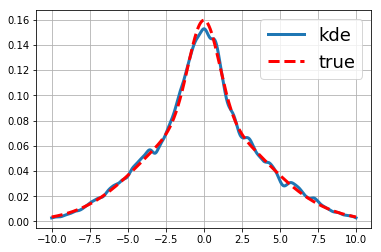

In [6]:
true_data_dist.plot_sample_density_against_true_density(X, figsize=(6,4))

In [7]:
model = MixtureOfTwoUnnormalisedGaussians(np.array([0, 0.5]), sigma1=sigma1)
no_latent_var_model = SumOfTwoUnnormalisedGaussians(np.array([0, 0.5]), sigma1=sigma1)  # for comparison
noise = GaussianNoise(mean=0, cov=sigma0**2)
var_dist = PolynomialSigmoidBernoulli(alpha=np.array([0,0,0]))

In [8]:
# E(r(x, z))
E1 = E_r
# E(log(psi_1(x, z)))
E2 = E_log_psi_1
# E((psi_1(x, z) - 1) / psi_1(x, z))
E3 = E_psi_1_ratio_times_grad_log_theta
# E(grad_theta(log(phi(u,z)) r(u, z))
E4 = E_r_times_grad_log_theta
# gradient_alpha(E(log(psi_1(x, z)))
E5 = grad_wrt_alpha_of_E_log_psi_1

In [9]:
nce_optimiser = NCEOptimiser(no_latent_var_model, noise, n, nu=nu, eps = 10**-20)
mc_optimiser = LatentNCEOptimiser(model, noise, var_dist, n, nu=nu, latent_samples_per_datapoint=nz, eps = 10**-20)
optimiser = LatentNCEOptimiserWithAnalyticExpectations(model, noise, var_dist, n,
                                                       E1, E2, E3, E4, E5, 
                                                       nu=nu, latent_samples_per_datapoint=nz, eps = 10**-20)

In order to obtain a lower bound on the first term in the NCE objective function, we need to specify a variational posterior distribution that can 'fill in' the missing values $z$.

As in the sanity check code, we use $p(z \ | \ x)$, which can be computed as:

\begin{align}
q_u(z=0 \ | \ u) & = p(z=0 \ | \ u) \\
             & = \frac{1}{1 + \exp(\frac{-u^2}{2} (\frac{1}{\sigma_1^2} + \frac{1}{\sigma_0^2}) )}
\end{align}

In [10]:
theta_ones = np.arange(0.01, 12, 0.1)
theta_zeros = np.arange(0.01, 4, 0.1) 
n_theta = len(theta_ones)
n_c = len(theta_zeros)

In [11]:
# NCE objective values
J = np.zeros((n_theta, n_c))
for k in range(n_theta):
    no_latent_var_model.theta[1] = np.log(theta_ones[k])
    for m in range(n_c):
        no_latent_var_model.theta[0] = theta_zeros[m]
        J[k, m] = nce_optimiser.compute_J1(X)

In [12]:
# Values of J1 for fixed variation q, with alpha=sigma0
# We plot both the analtic and monte-carlo J1
alpha_2 = 0.5*((1/sigma0**2) + (1/sigma1**2))
var_dist.alpha = np.array([0, 0, alpha_2])
ZX, ZY = var_dist.sample(nz, X), var_dist.sample(nz, mc_optimiser.Y)

J1 = np.zeros((n_theta, n_c))
J1_mc = np.zeros((n_theta, n_c))
for k in range(n_theta):
    model.theta[1] = np.log(theta_ones[k])
    for m in range(n_c):
        model.theta[0] = theta_zeros[m]
        J1[k, m] = optimiser.compute_J1(X)
        J1_mc[k, m] = mc_optimiser.compute_J1(X, ZX, ZY)

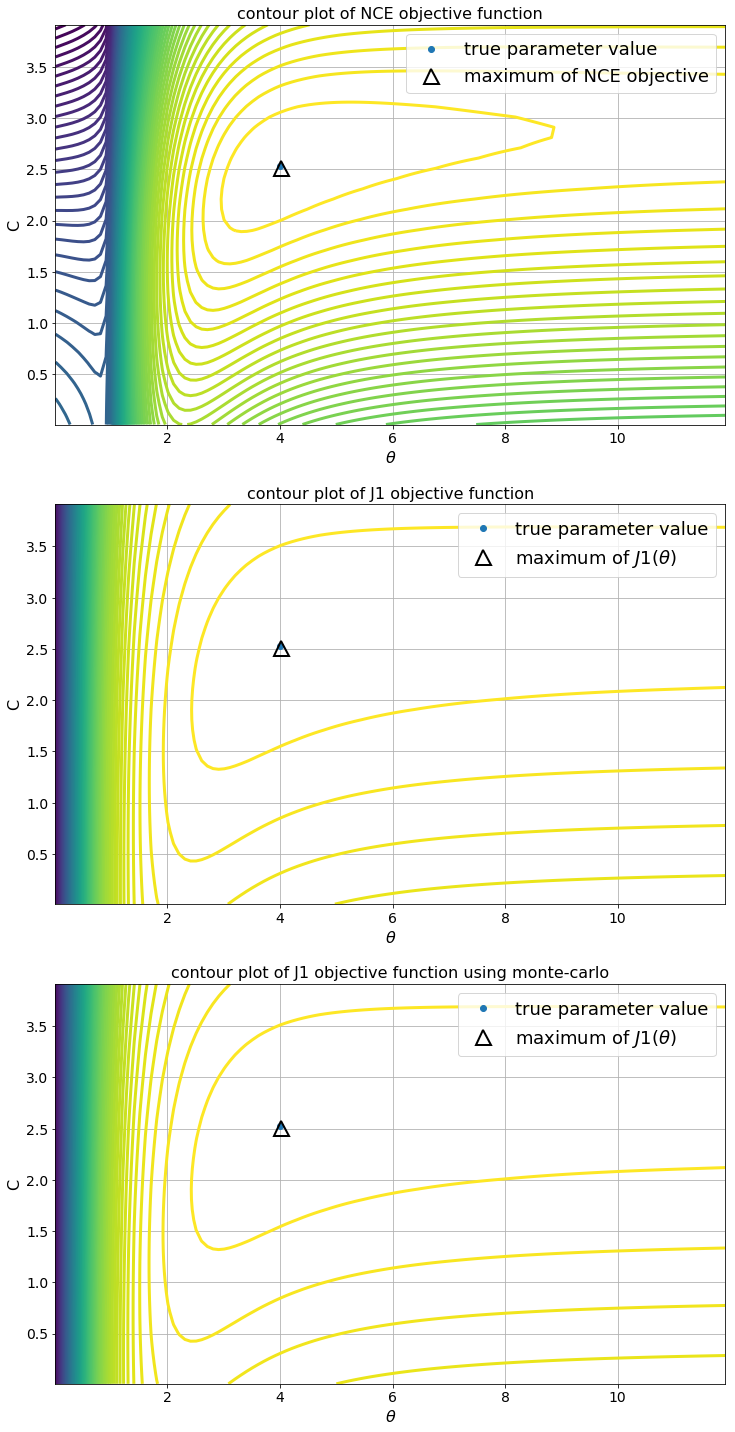

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(12,25))

XX, YY = np.meshgrid(theta_ones, theta_zeros)

# Plot true NCE objective function
ax[0].contour(XX, YY, J.T, 100)
ax[0].plot(sigma0, c0,'o', label='true parameter value')

# Plot maximum of NCE objective
index = np.argmax(J) # this is the index for the flattened array
row = int(index/n_c)
column = index % n_c
ax[0].plot(theta_ones[row], theta_zeros[column], marker='^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label='maximum of NCE objective')

# Plot lower bound J1 objective function
ax[1].contour(XX, YY, J1.T, 100)
ax[1].plot(sigma0, c0,'o', label='true parameter value')

# Plot monte carlo lower bound J1 objective function
ax[2].contour(XX, YY, J1_mc.T, 100)
ax[2].plot(sigma0, c0,'o', label='true parameter value')

index3 = np.argmax(J1) # this is the index for the flattened array
row3 = int(index3/n_c)
column3 = index3 % n_c
ax[1].plot(theta_ones[row3], theta_zeros[column3], marker='^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label=r'maximum of $J1(\theta)$')

index4 = np.argmax(J1_mc) # this is the index for the flattened array
row4 = int(index4/n_c)
column4 = index4 % n_c
ax[2].plot(theta_ones[row4], theta_zeros[column4], marker='^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label=r'maximum of $J1(\theta)$')

ax[0].set_title('contour plot of NCE objective function', fontsize=16)
ax[1].set_title('contour plot of J1 objective function', fontsize=16)
ax[2].set_title('contour plot of J1 objective function using monte-carlo', fontsize=16)

ax[0].set_xlabel(r'$\theta$', fontsize=16)
ax[0].set_ylabel('C', fontsize=16)
ax[1].set_xlabel(r'$\theta$', fontsize=16)
ax[1].set_ylabel('C', fontsize=16)
ax[2].set_xlabel(r'$\theta$', fontsize=16)
ax[2].set_ylabel('C', fontsize=16)
ax[0].tick_params(axis='x', which='major', labelsize=14)
ax[0].tick_params(axis='y', which='major', labelsize=14)
ax[1].tick_params(axis='x', which='major', labelsize=14)
ax[1].tick_params(axis='y', which='major', labelsize=14)
ax[2].tick_params(axis='x', which='major', labelsize=14)
ax[2].tick_params(axis='y', which='major', labelsize=14)

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].legend(loc='best', numpoints=1)
ax[1].legend(loc='best', numpoints=1)
ax[2].legend(loc='best', numpoints=1)

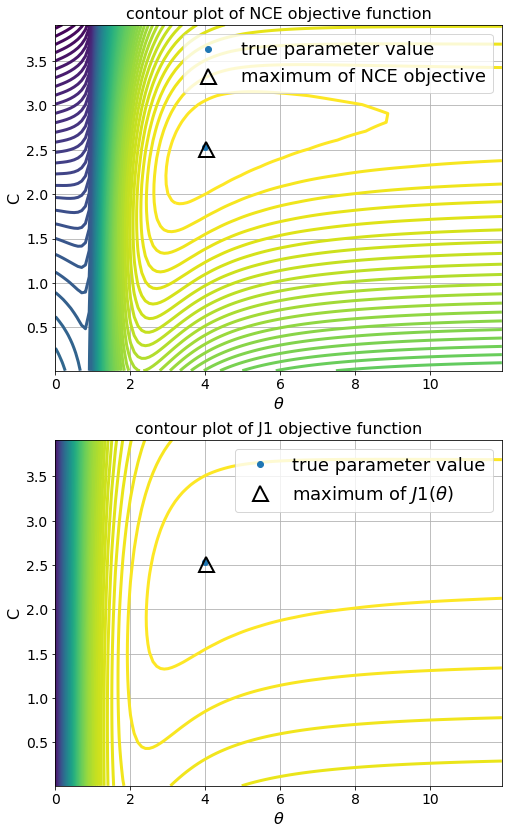

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(8,14))

XX, YY = np.meshgrid(theta_ones, theta_zeros)

# Plot true NCE objective function
ax[0].contour(XX, YY, J.T, 100)
ax[0].plot(sigma0, c0,'o', label='true parameter value')

# Plot maximum of NCE objective
index = np.argmax(J) # this is the index for the flattened array
row = int(index/n_c)
column = index % n_c
ax[0].plot(theta_ones[row], theta_zeros[column], marker='^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label='maximum of NCE objective')

# Plot lower bound J1 objective function
ax[1].contour(XX, YY, J1.T, 100)
ax[1].plot(sigma0, c0,'o', label='true parameter value')

index3 = np.argmax(J1) # this is the index for the flattened array
row3 = int(index3/n_c)
column3 = index3 % n_c
ax[1].plot(theta_ones[row3], theta_zeros[column3], marker='^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label=r'maximum of $J1(\theta)$')

ax[0].set_title('contour plot of NCE objective function', fontsize=16)
ax[1].set_title('contour plot of J1 objective function', fontsize=16)

ax[0].set_xlabel(r'$\theta$', fontsize=16)
ax[0].set_ylabel('C', fontsize=16)
ax[1].set_xlabel(r'$\theta$', fontsize=16)
ax[1].set_ylabel('C', fontsize=16)
ax[0].tick_params(axis='x', which='major', labelsize=14)
ax[0].tick_params(axis='y', which='major', labelsize=14)
ax[1].tick_params(axis='x', which='major', labelsize=14)
ax[1].tick_params(axis='y', which='major', labelsize=14)

ax[0].grid()
ax[1].grid()

ax[0].legend(loc='best', numpoints=1)
ax[1].legend(loc='best', numpoints=1)

fig.savefig('../../figs/unnormalised-mog-countour.pdf')

In [15]:
print('J1 is a lower bound for {}% of the parameters'.format(100* np.sum(J1 < J) / J.size))
print('J1 estimated with Monte carlo is a lower bound for {}% of the parameters'.format(100* np.sum(J1_mc < J) / J.size))

J1 is a lower bound for 89.0625% of the parameters
J1 estimated with Monte carlo is a lower bound for 68.35416666666667% of the parameters


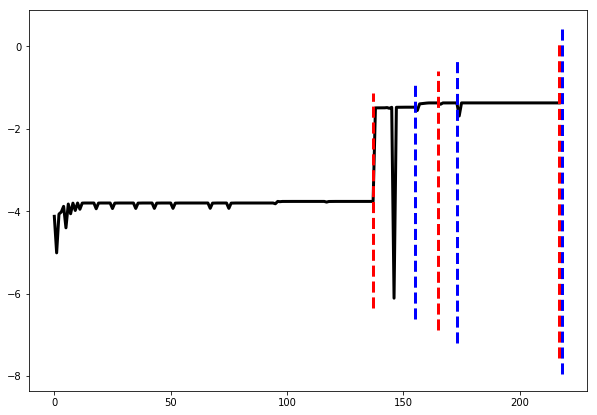

In [16]:
thetas_per_em, alpha_per_em, J1s, J1_grads = optimiser.fit(X, theta0=theta0,
                                                           alpha0=alpha0, 
                                                           disp=True, stop_threshold=10**-5)

In [17]:
print('Latent nce parameter estimates are: \n'
      'scaling parameter: {} \n'
      'standard deviation: {}'.format(thetas_per_em[-1][0], 
                                      np.exp(thetas_per_em[-1][1])))

Latent nce parameter estimates are: 
scaling parameter: 2.5203008966082323 
standard deviation: 3.975304259297637


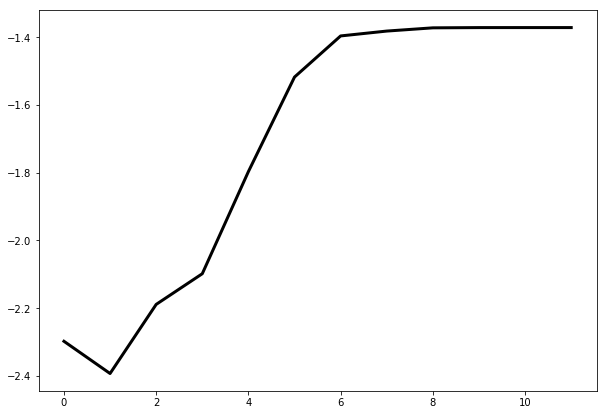

In [18]:
J1s, J1_grads = nce_optimiser.fit(X, theta0=theta0)

In [21]:
J1s

array([-2.29738581, -2.39248594, -2.18863433, -2.09807252, -1.7967975 ,
       -1.51784809, -1.39652333, -1.38216679, -1.3726381 , -1.37191512,
       -1.37186359, -1.37186304])

In [19]:
print('nce parameter estimates are: \n'
      'scaling parameter: {} \n'
      'standard deviation: {}'.format(no_latent_var_model.theta[0], 
                                      np.exp(no_latent_var_model.theta[1])))

nce parameter estimates are: 
scaling parameter: 2.5285580286093094 
standard deviation: 4.002613598381816


In [20]:
print('True parameters are: \n'
      'scaling parameter: {} \n'
      'standard deviation: {}'.format(true_theta[0], np.exp(true_theta[1])))

True parameters are: 
scaling parameter: 2.5283764456387727 
standard deviation: 4.0
